In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

data_path = './../../data/processed/'

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# for col in ['CN ID 8', 'CPA6', 'ID', 'VAT', 'DEPT', 'PYOD']:
    
#     df = pd.read_csv(data_path + col.replace(' ', '_')+'_YM.csv')
#     df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')
    

# Data

In [4]:
col = 'ID'
df = pd.read_csv(data_path + col.replace(' ', '_')+'_YM.csv')
df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')


## Growth rates again

In [5]:
n = 12 #rolling and 'prev_' period

df_level_g_list = []
for i in [0, 1]:

    cuadro = df.loc[df.IMPORT == i].set_index(['ID', 'date'])[['VART']].unstack()

    # Firms present in at least two separate months
    cuadro = cuadro.loc[cuadro.count(1) > 12*5].fillna(0)

    cuadro_rolled = cuadro.rolling(n, axis = 1, center=True).sum()
    cuadro_rolled = cuadro_rolled.dropna(axis = 1, how = 'all')
    # cuadro_rolled = cuadro

    annual_logdiff = np.log10(cuadro_rolled).diff(n, axis = 1).dropna(how = 'all')
    annual_logdiff_prev = annual_logdiff.shift(n, axis = 1).dropna(how = 'all')
    annual_log = np.log10(cuadro_rolled.reindex(annual_logdiff_prev.index))

    annual_log.columns = annual_log.columns.set_levels(annual_log.columns.levels[0].str.replace('VART', 'annual_log'), level=0)
    annual_logdiff_prev.columns = annual_logdiff_prev.columns.set_levels(annual_logdiff_prev.columns.levels[0].str.replace('VART', 'annual_logdiff_prev'), level=0)
    annual_logdiff.columns = annual_logdiff.columns.set_levels(annual_logdiff.columns.levels[0].str.replace('VART', 'annual_logdiff'), level=0)

    df_concat = pd.concat([annual_log, annual_logdiff, annual_logdiff_prev], axis = 1)
    df_concat.shape

    df_level_g = df_concat.stack().dropna()

#     df_level_g['annual_logdiff_bin'] = pd.cut(df_level_g['annual_logdiff'], np.arange(-1, 1, .03))
    df_level_g = df_level_g.dropna()
    
    df_level_g_list += [df_level_g]

KeyError: MemoryError()

In [ ]:
# july_cols = [c for c in df_level_g['annual_logdiff'].unstack().columns if c.month == 7]

# july_annual_logdiff = df_level_g['annual_logdiff'].unstack()[july_cols]
# july_annual_logdiff.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna().std()

### Fit growth dists

In [ ]:
import numpy as np

from scipy.optimize import curve_fit
def parabola(x, a, b, c):
    return a * x**2 + b * x + c

def growth_rates(x, xc, a, b, k1, k2):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return - np.power(abs(x - xc)/b, a) + k1 + k2*(x-xc)

def baseline(x, xc, k1, k2):
    return k1 + k2*(x-xc)

def bell(x, xc, a, b):
    return -np.power(abs(x - xc)/b, a)



In [ ]:
# # matplotlib.rcParams.update({'font.size': 22})
# fig, axs = plt.subplots(3,2, figsize = (14, 18))

# gibrat_list = []

# for i in [0, 1]:   
#     df_level_g = df_level_g_list[i]

#     df_level_g['annual_log_bin'] = pd.cut(df_level_g['annual_log'], np.arange(4, 10, .5))
#     df_level_g['annual_logdiff_bin'] = pd.cut(df_level_g['annual_logdiff'], np.arange(-1.5, 1.5, .04))
#     df_level_g = df_level_g.dropna()

#     ax = axs[0, i]
#     ax.set_title('Growth rates distribution \n '+['EXPORTS', 'IMPORTS'][i])
#     result_list = []
#     re_std_list = []

#     bins = np.arange(5, 9, .5)
#     for s in bins:
#         section = df_level_g.loc[abs(df_level_g.annual_log - s) < .5]

#         section = df_level_g.loc[abs(df_level_g.annual_log - s) < .5]
#         counts = section.groupby('annual_logdiff_bin')['annual_logdiff'].count()

#         x = np.array([b.mid for b in counts.index])
#         y = np.log(counts/counts.sum()).values

#         counts_df = pd.DataFrame([x, y]).T.replace(-np.inf, np.nan).dropna()
#         counts_df.columns = ['g_rate', 'ln_PDF']

#         # Make a copy where only fat tail values are kept
#         counts_df_FT = counts_df.copy()
#         counts_df_FT['ln_PDF'] = counts_df_FT['ln_PDF'].clip(-np.inf, -2.5).replace(-2.5, np.nan)
#         fit_data = counts_df_FT.dropna()
#         ydata = fit_data.ln_PDF.values
#         xdata = fit_data.g_rate.values
        
        
#         try:
#             k1_suggested = -abs(s - 7.5) + 1.49
#             k2_suggested = .8*(s - 6.7)
            
#             p0 = np.array([0.02, 0.5, .05, k1_suggested, k2_suggested])
#             bounds = ([-0.05, .2, 0.001, -2, -2], [0.05, 1.2, 0.15, 2, 1.7])
#             popt, pcov = curve_fit(growth_rates, xdata, ydata, 
#                                    sigma = abs(fit_data.ln_PDF - (fit_data.ln_PDF.shift() + fit_data.ln_PDF.shift(-1))/2.).interpolate(limit_direction = 'both', limit = 1), absolute_sigma = True,
#                                    p0 = p0, bounds = bounds)
#             errs = np.sqrt(np.diag(pd.DataFrame(pcov)))

# #             if s == 6.5:

#             bound_upper = growth_rates(counts_df_FT.g_rate, *(popt + errs))
#             bound_lower = growth_rates(counts_df_FT.g_rate, *(popt - errs))
# #             ax.fill_between(counts_df_FT.g_rate, bound_lower, bound_upper,
# #                          color = 'r', alpha = 0.2)
#             data, = ax.plot(counts_df.g_rate, counts_df.ln_PDF, 'b-', marker = '.', c = '.5', alpha = .7)
# #             y_best = growth_rates(counts_df_FT.g_rate, *popt).clip(-np.inf, -2.5).replace(-2.5, np.nan)
# #             fit, = ax.plot(counts_df_FT.g_rate, y_best, 
# #                      'r-', label='fit: xc=%5.3f,  a=-%5.2f,  b=%5.2f' % tuple(popt[[0, 1, 2]]), alpha = .7)
#             y_best = bell(counts_df_FT.g_rate, *popt[[0, 1, 2]])#.clip(-np.inf, -2.5).replace(-2.5, np.nan)
#             fit, = ax.plot(counts_df_FT.g_rate, y_best, 
#                      'g-', alpha = .7)
#             y_best = baseline(counts_df_FT.g_rate, *popt[[0, 3, 4]])#.clip(-np.inf, -2.5).replace(-2.5, np.nan)
#             fit, = ax.plot(counts_df_FT.g_rate, y_best, 
#                      'b-', alpha = .7)
#             ax.axvline(0, c = '.5', alpha = .4)

#             result_list += [popt]
#             re_std_list += [errs]
            
#         except:
#             print(i, s)
#             print('fit fail')
#             print(p0)
#             result_list += [popt]
#             re_std_list += [errs]
        
#     ax.legend((data, fit), ('data', 'fit'))
#     ax.set_xlabel('log growth rate. \n (Year exports from 300k to 3mn EUR)')
#     ax.set_ylabel('PDF (ln)')
# #     ax.set_ylim(-10, 0)


#     params = pd.DataFrame(np.array(result_list), columns = ['xc', 'a', 'b', 'k1', 'k2'], index = bins)
#     errs = pd.DataFrame(np.array(re_std_list), columns = ['xc', 'a', 'b', 'k1', 'k2'], index = bins)

#     gibrat_test = pd.concat([params.add_suffix('_m'), (10*errs).add_suffix('_std')], axis = 1)
#     gibrat_list += [gibrat_test]

#     # Little trick, drop bad point
# #     if i == 1: gibrat_test = gibrat_test.drop(8)
#     ax = axs[1, i]
#     ax.set_title("Parameters' dependence w/size \n "+['EXPORTS', 'IMPORTS'][i])
    
#     for k,col in enumerate(params.columns[[1, 3, 4]]):
#         x = gibrat_test.index
#         gibrat_test.plot(y = col + '_m', xerr=.25, yerr=col + '_std', marker = 'o', ax = ax, linestyle = '--',
#                         label=[r'$a$', r'$k_1$', r'$k_2$'][k])
#     ax.axhline(0, c = '.5')
#     ax.set_xlim(min(bins) - .5, max(bins) + .5)
#     ax.set_ylim(-2, 2)
#     ax.set_ylabel('Optimal fitted parameter')
#     ax.set_xlabel(['Exporter', 'Importer'][i] + ' log size')
    

#     ax = axs[2, i]
# #     ax.set_title("Parameters' dependence w/size \n "+['EXPORTS', 'IMPORTS'][i])
    
#     for k,col in enumerate(params.columns[[0, 2]]):
#         x = gibrat_test.index
#         gibrat_test.plot(y = col + '_m', xerr=.25, yerr=col + '_std', marker = 'o', ax = ax, linestyle = '--',
#                         label=[r'$x_c$', r'$b$'][k])
#     ax.axhline(0, c = '.5')
#     ax.set_xlim(min(bins) - .5, max(bins) + .5)
#     ax.set_ylim(-.05, .1)
#     ax.set_ylabel('Optimal fitted parameter')
#     ax.set_xlabel(['Exporter', 'Importer'][i] + ' log size')
    
# plt.tight_layout()
# plt.savefig('./../../../thesis_writing/figures/growth_dist_gibrat_detail.png', dpi = 300)
# plt.show()

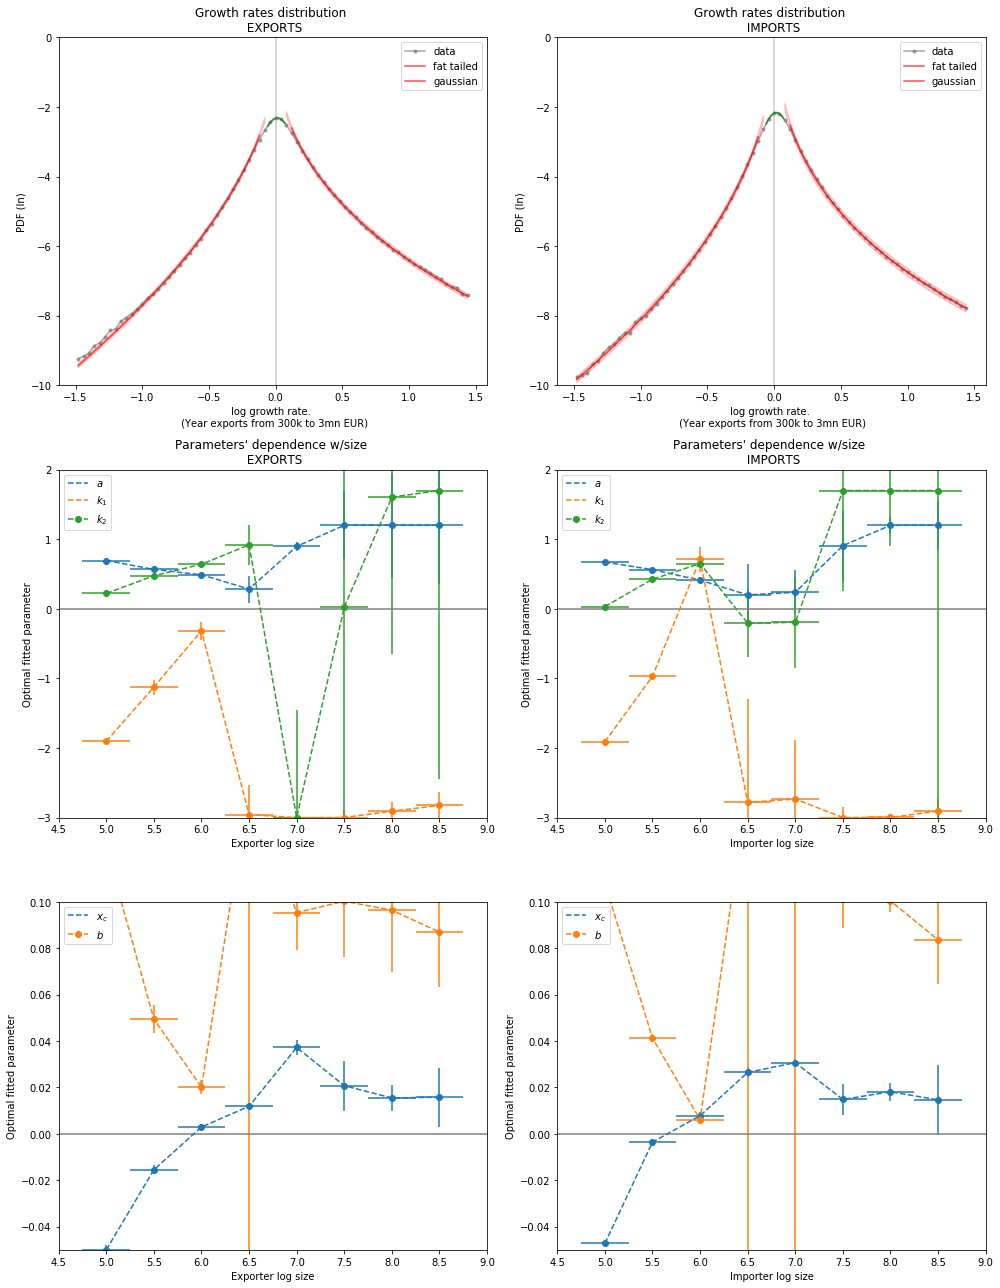

In [28]:
debug = []

# matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(3,2, figsize = (14, 18))

gibrat_list = []

for i in [0, 1]:   
    df_level_g = df_level_g_list[i]

    df_level_g['annual_log_bin'] = pd.cut(df_level_g['annual_log'], np.arange(4, 10, .5))
    df_level_g['annual_logdiff_bin'] = pd.cut(df_level_g['annual_logdiff'], np.arange(-1.5, 1.5, .04))
#     df_level_g = df_level_g.dropna()

    ax = axs[0, i]
    ax.set_title('Growth rates distribution \n '+['EXPORTS', 'IMPORTS'][i])
    result_list = []
    re_std_list = []

    bins = np.arange(5, 9, .5)
#     bins = np.arange(6, 7.5, .5)
    for s in bins:
        section = df_level_g.loc[abs(df_level_g.annual_log - s) < .5]
        N = len(section)
        counts = section.dropna().groupby('annual_logdiff_bin')['annual_logdiff'].count()

        x = np.array([b.mid for b in counts.index])
        y = np.log(counts/N).values

        counts_df = pd.DataFrame([x, y]).T.replace(-np.inf, np.nan).dropna()
        counts_df.columns = ['g_rate', 'ln_PDF']

        # Make a copy where only fat tail values are kept
        counts_df_FT = counts_df.copy()
        counts_df_FT['ln_PDF'] = counts_df_FT['ln_PDF'].clip(-np.inf, -2.5).replace(-2.5, np.nan)
        fit_data = counts_df_FT.dropna()
        ydata = fit_data.ln_PDF.values
        xdata = fit_data.g_rate.values
        
        
        try:
            k1_suggested = -abs(s - 7.5) + 1.49
            k2_suggested = .8*(s - 6.7)

            p0 = np.array([0.02, 0.5, .05, k1_suggested, k2_suggested])
            bounds = ([-0.05, .2, 0.001, -3, -3], [0.05, 1.2, 0.15, 3, 1.7])
            popt, pcov = curve_fit(growth_rates, xdata, ydata, 
                                   sigma = abs(fit_data.ln_PDF - (fit_data.ln_PDF.shift() + fit_data.ln_PDF.shift(-1))/2.).interpolate(limit_direction = 'both', limit = 1), absolute_sigma = True,
                                   p0 = p0, bounds = bounds)
            errs = np.sqrt(np.diag(pd.DataFrame(pcov)))

            if s == 6:

                bound_upper = growth_rates(counts_df_FT.g_rate, *(popt + 3*errs))
                bound_lower = growth_rates(counts_df_FT.g_rate, *(popt - 3*errs))

                ax.fill_between(counts_df_FT.g_rate.loc[abs(counts_df_FT.g_rate - 0.005) > 0.07].reindex(counts_df_FT.index), 
                                bound_lower.loc[abs(counts_df_FT.g_rate - 0.005) > 0.07].reindex(counts_df_FT.index), 
                                bound_upper.loc[abs(counts_df_FT.g_rate - 0.005) > 0.07].reindex(counts_df_FT.index),
                             color = 'r', alpha = 0.2)
                data, = ax.plot(counts_df.g_rate, counts_df.ln_PDF, 'b-', marker = '.', c = '.5', alpha = .7)
                debug += [counts_df]
                y_best = growth_rates(counts_df_FT.g_rate, *popt).clip(-np.inf, -2.5).replace(-2.5, np.nan)
                fit, = ax.plot(counts_df_FT.g_rate, y_best, 
                         'r-', label='subbotin fit', alpha = .7)
                ax.axvline(0, c = '.5', alpha = .4)
                   
            result_list += [popt]
            re_std_list += [errs]
        
        
        ### FIT GREEN PART IN THE MIDDLE
            if s ==6:
                df_level_g['annual_logdiff_bin'] = pd.cut(df_level_g['annual_logdiff'], np.arange(-.065, .075, .01)); # Quantile cut

                ax = axs[0, i]

                section = df_level_g.loc[abs(df_level_g.annual_log - s) < .5]
                N = len(section)
                counts = section.dropna().groupby('annual_logdiff_bin')['annual_logdiff'].count()

                x = np.array([b.mid for b in counts.index])
                y = np.log(counts/N).values + np.log(4)#+ [0.26, 0.39][i]

                counts_df = pd.DataFrame([x, y]).T.replace(-np.inf, np.nan).dropna()
                counts_df.columns = ['g_rate', 'ln_PDF']

                fit_data = counts_df
                ydata = fit_data.ln_PDF.values
                xdata = fit_data.g_rate.values

                uncertainty_suggestion = abs(fit_data.ln_PDF - (fit_data.ln_PDF.shift() + fit_data.ln_PDF.shift(-1))/2.).interpolate(limit_direction = 'both', limit = 1)

                popt, pcov = curve_fit(parabola, xdata, ydata, 
                                       sigma = uncertainty_suggestion, absolute_sigma = True)


                errs = np.sqrt(np.diag(pd.DataFrame(pcov)))

                bound_upper = parabola(counts_df.g_rate, *(popt + 3*errs))
                bound_lower = parabola(counts_df.g_rate, *(popt - 3*errs))
                ax.fill_between(counts_df.g_rate, bound_lower, bound_upper,
                             color = 'g', alpha = 0.2)
                debug += [counts_df]
#                 data, = ax.plot(counts_df.g_rate, counts_df.ln_PDF, 'b-', marker = 'd', c = '.5', alpha = .7)
                y_best = parabola(counts_df.g_rate, *popt)#.clip(-np.inf, -2.5).replace(-2.5, np.nan)
                fit2, = ax.plot(counts_df.g_rate, y_best, 
                         'g-', label='normal fit', alpha = .7)
        

        except:
            print(i, s)
            print('fit fail')
            print(p0)
            result_list += [popt]
            re_std_list += [errs]   
                        
    ax.legend((data, fit, fit), ('data', 'fat tailed', 'gaussian'))
    ax.set_xlabel('log growth rate. \n (Year exports from 300k to 3mn EUR)')
    ax.set_ylabel('PDF (ln)')
    ax.set_ylim(-10, 0)


    params = pd.DataFrame(np.array(result_list), columns = ['xc', 'a', 'b', 'k1', 'k2'], index = bins)
    errs = pd.DataFrame(np.array(re_std_list), columns = ['xc', 'a', 'b', 'k1', 'k2'], index = bins)

    gibrat_test = pd.concat([params.add_suffix('_m'), (10*errs).add_suffix('_std')], axis = 1)
    gibrat_list += [gibrat_test]

    # Little trick, drop bad point
#     if i == 1: gibrat_test = gibrat_test.drop(8)
    ax = axs[1, i]
    ax.set_title("Parameters' dependence w/size \n "+['EXPORTS', 'IMPORTS'][i])
    
    for k,col in enumerate(params.columns[[1, 3, 4]]):
        x = gibrat_test.index
        gibrat_test.plot(y = col + '_m', xerr=.25, yerr=col + '_std', marker = 'o', ax = ax, linestyle = '--',
                        label=[r'$a$', r'$k_1$', r'$k_2$'][k])
    ax.axhline(0, c = '.5')
    ax.set_xlim(min(bins) - .5, max(bins) + .5)
    ax.set_ylim(-3, 2)
    ax.set_ylabel('Optimal fitted parameter')
    ax.set_xlabel(['Exporter', 'Importer'][i] + ' log size')
    

    ax = axs[2, i]
#     ax.set_title("Parameters' dependence w/size \n "+['EXPORTS', 'IMPORTS'][i])
    
    for k,col in enumerate(params.columns[[0, 2]]):
        x = gibrat_test.index
        gibrat_test.plot(y = col + '_m', xerr=.25, yerr=col + '_std', marker = 'o', ax = ax, linestyle = '--',
                        label=[r'$x_c$', r'$b$'][k])
    ax.axhline(0, c = '.5')
    ax.set_xlim(min(bins) - .5, max(bins) + .5)
    ax.set_ylim(-.05, .15)
    ax.set_ylabel('Optimal fitted parameter')
    ax.set_xlabel(['Exporter', 'Importer'][i] + ' log size')      
    
    ax = axs[1, i]
    ax.plot(bins, )

plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/growth_dist_gibrat.png', dpi = 300)
plt.show()

## Fit of Gaussian small growth rates

In [9]:
import json
vardict = json.load(open("variables.json"))
def add_entry(vardict, name, element):
    vardict[name]= element
    return vardict

In [10]:
varnames_list = []

for i in [0, 1]:   
    df_level_g = df_level_g_list[i]
    a = df_level_g.shape
#     print(a)
    df_level_g = df_level_g.loc[abs(df_level_g.annual_logdiff - 0.015) < .075]
    b = df_level_g.shape
#     print(b)
#     print(100*b[0]/a[0])    
    varnames_list += ['gbtest'+['Exp', 'Imp'][i]+'gaussian_rates_pct', str(round(100*b[0]/a[0], 1))],

# What fraction of growth rates are in the normal regime...
print(varnames_list)

[['gbtestExpgaussian_rates_pct', '28.7'], ['gbtestImpgaussian_rates_pct', '33.5']]


In [11]:
gibrat_list = []

bins = np.arange(5, 9, .5)
fig, axs = plt.subplots(len(bins),2, figsize = (12, 5*len(bins)))

for i in [0, 1]:   
    df_level_g = df_level_g_list[i]
    df_level_g = df_level_g.loc[abs(df_level_g.annual_logdiff - 0.015) < .075]

    df_level_g['annual_log_bin'] = pd.cut(df_level_g['annual_log'], np.arange(4, 10, .5))
    df_level_g['annual_logdiff_bin'] = pd.cut(df_level_g['annual_logdiff'], np.arange(-.06, .08, .01)); # Quantile cut
    df_level_g = df_level_g.dropna()

#     ax.set_title('Growth rates distribution \n '+['EXPORTS', 'IMPORTS'][i])
    result_list = []
    re_std_list = []

    for j,s in enumerate(bins):
        ax = axs[j, i]

        section = df_level_g.loc[abs(df_level_g.annual_log - s) < .5]
        counts = section.groupby('annual_logdiff_bin')['annual_logdiff'].count()

        x = np.array([b.mid for b in counts.index])
        y = np.log(counts/counts.sum()).values

        counts_df = pd.DataFrame([x, y]).T.replace(-np.inf, np.nan).dropna()
        counts_df.columns = ['g_rate', 'ln_PDF']

        fit_data = counts_df
        ydata = fit_data.ln_PDF.values
        xdata = fit_data.g_rate.values

        uncertainty_suggestion = abs(fit_data.ln_PDF - (fit_data.ln_PDF.shift() + fit_data.ln_PDF.shift(-1))/2.).interpolate(limit_direction = 'both', limit = 1)

        popt, pcov = curve_fit(parabola, xdata, ydata, 
                               sigma = uncertainty_suggestion, absolute_sigma = True)


        errs = np.sqrt(np.diag(pd.DataFrame(pcov)))

        bound_upper = parabola(counts_df.g_rate, *(popt + 3*errs))
        bound_lower = parabola(counts_df.g_rate, *(popt - 3*errs))
        ax.fill_between(counts_df.g_rate, bound_lower, bound_upper,
                     color = 'g', alpha = 0.2)
        data, = ax.plot(counts_df.g_rate, counts_df.ln_PDF, 'b-', marker = '.', c = '.5', alpha = .7)
        y_best = parabola(counts_df.g_rate, *popt).clip(-np.inf, -2.5).replace(-2.5, np.nan)
        fit, = ax.plot(counts_df.g_rate, y_best, 
                 'g-', label='fit: xc=%5.3f,  a=-%5.2f,  b=%5.2f' % tuple(popt[[0, 1, 2]]), alpha = .7)
        ax.axvline(0, c = '.5', alpha = .4)

In [12]:
## Compare abundance of Fat Tails vs gaussian regime.

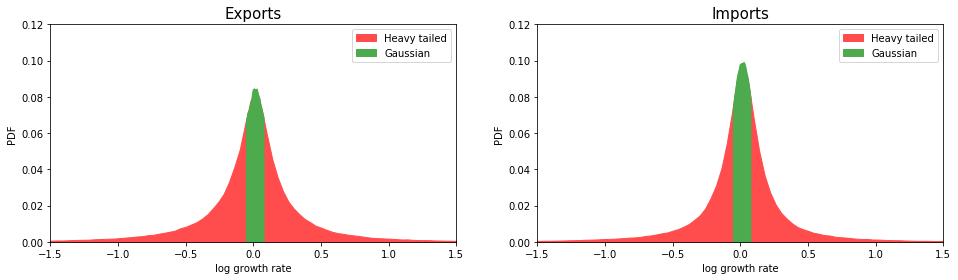

In [13]:
fig, axs = plt.subplots(1, 2, figsize = (16, 4))

for i in [0, 1]:   
    df_level_g = df_level_g_list[i].sample(frac = .05)
    df_level_g['annual_log_bin'] = pd.cut(df_level_g['annual_log'], np.arange(4, 10, .5))
    
    # separate it into 2:
    df_level_g_gauss = df_level_g.loc[abs(df_level_g.annual_logdiff - 0.015) < .075]
    
    # HISTOGRAMS (linear y)
    ax = axs[i]
    ax.set_title(['Exports', 'Imports'][i], fontsize = 15)
#     color = ['#1f77b4', '#ff7f0e'][k]
    
    for p, df_ in enumerate([df_level_g, df_level_g_gauss]):
        color = ['r', 'g'][p]
        bin_w = [.04, .01][p]
        label = ['Heavy tailed', 'Gaussian'][p]
        bins_ = [np.arange(-1.6, 1.6, bin_w), np.arange(-.06, .08, bin_w)][p]
        df_['annual_logdiff_bin'] = pd.cut(df_['annual_logdiff'], bins_); # Quantile cut
        
        hist = df_.groupby('annual_logdiff_bin').count().iloc[:, 0];
        hist = hist.loc[hist.values > 0]
        hist = hist/len(df_level_g)*(0.04/bin_w) # pass counts to PDF so to have the same y scale on both parts
#         if p == 0: print(hist.sum()) # see it is around 1
        x_ = [b.mid for b in hist.index]
        ax.fill_between(x_, hist.values, 0, color = sns.light_palette(color, 10).as_hex()[6],
                       label = label)

    ax.legend()
    ax.set_xlabel('log growth rate')
    ax.set_ylabel('PDF')
    ax.set_ylim(0, .12)
    ax.set_xlim(-1.5, 1.5)
    
plt.savefig('./../../../thesis_writing/figures/gaussian_growth_dists.png', bbox_inches='tight')
plt.show()

### Save dynamic variables

In [14]:
import json

vardict = json.load(open("variables.json"))
def add_entry(vardict, name, element):
    vardict[name]= element
    return vardict

In [15]:
import math

def myround(n):
    if n == 0:
        return 0
    sgn = -1 if n < 0 else 1
    scale = int(-math.floor(math.log10(abs(n))))
    if scale <= 0:
        scale = 1
    factor = 20**scale
    return sgn*math.floor(abs(n)*factor)/factor


In [16]:
varnames_list = []

for i in [0, 1]:
    gibrat_test = gibrat_list[i]
    
    long_gb_result = gibrat_test.T[gibrat_test.columns.str.contains('_m')].T.describe().loc[['mean', 'std']].stack()
    long_gb_result = pd.DataFrame(long_gb_result)

    for j, row in long_gb_result.iterrows():
        varname = 'gbtest'+['Exports', 'Imports'][i][:3]+'_'.join(j)
        varnames_list += [[varname, str(myround(row.values[0]))]]

    for var in varnames_list:
        res = add_entry(vardict, *var)

    f = open("variables.json","w")
    f.write(json.dumps(res))
    f.close()

varnames_list

[['gbtestExpmean_xc_m', '0.005625'],
 ['gbtestExpmean_a_m', '0.3'],
 ['gbtestExpmean_b_m', '0.03'],
 ['gbtestExpmean_k1_m', '-1.65'],
 ['gbtestExpmean_k2_m', '0.3'],
 ['gbtestExpstd_xc_m', '0.025'],
 ['gbtestExpstd_a_m', '0.2'],
 ['gbtestExpstd_b_m', '0.04'],
 ['gbtestExpstd_k1_m', '0.6'],
 ['gbtestExpstd_k2_m', '0.5'],
 ['gbtestImpmean_xc_m', '0.00875'],
 ['gbtestImpmean_a_m', '0.35'],
 ['gbtestImpmean_b_m', '0.025'],
 ['gbtestImpmean_k1_m', '-1.5'],
 ['gbtestImpmean_k2_m', '0.3'],
 ['gbtestImpstd_xc_m', '0.025'],
 ['gbtestImpstd_a_m', '0.15'],
 ['gbtestImpstd_b_m', '0.035'],
 ['gbtestImpstd_k1_m', '0.95'],
 ['gbtestImpstd_k2_m', '1.4']]

## Dependence of std of growth rates with size.

In [17]:
#### The 'colorful trajectories' Phase diagram type, we should be able to plot it here. 



In [ ]:
n = 12 #rolling and 'prev_' period

df_level_g_list = []
for i in [0, 1]:

    cuadro = df.loc[df.IMPORT == i].set_index(['ID', 'date'])[['VART']].unstack()

    # Firms present in at least two separate months
    cuadro = cuadro.loc[cuadro.count(1) > 12*5].fillna(0)

    cuadro_rolled = cuadro.rolling(n, axis = 1, center=True).sum()
    cuadro_rolled = cuadro_rolled.dropna(axis = 1, how = 'all')
    # cuadro_rolled = cuadro

    annual_logdiff = np.log10(cuadro_rolled).diff(n, axis = 1).dropna(how = 'all')
    annual_logdiff_prev = annual_logdiff.shift(n, axis = 1).dropna(how = 'all')
    annual_log = np.log10(cuadro_rolled.reindex(annual_logdiff_prev.index))

    annual_log.columns = annual_log.columns.set_levels(annual_log.columns.levels[0].str.replace('VART', 'annual_log'), level=0)
    annual_logdiff_prev.columns = annual_logdiff_prev.columns.set_levels(annual_logdiff_prev.columns.levels[0].str.replace('VART', 'annual_logdiff_prev'), level=0)
    annual_logdiff.columns = annual_logdiff.columns.set_levels(annual_logdiff.columns.levels[0].str.replace('VART', 'annual_logdiff'), level=0)

    df_concat = pd.concat([annual_log, annual_logdiff, annual_logdiff_prev], axis = 1)
    df_concat.shape

    df_level_g = df_concat.stack().dropna()

#     df_level_g['annual_logdiff_bin'] = pd.cut(df_level_g['annual_logdiff'], np.arange(-1, 1, .03))
    df_level_g = df_level_g.dropna()
    
    df_level_g_list += [df_level_g]

In [ ]:
fig, axs = plt.subplots(3,2, figsize = (16, 18))

for i in [0, 1]:
    df_level_g = df_level_g_list[i].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()

    ## PLOT
    #Scatter
    ax = axs[0][i]    
    df_level_g['annual_log_bin'] = pd.cut(df_level_g['annual_log'], np.arange(4, 10, .15))
    samples = df_level_g.groupby('annual_log_bin', observed = True)[['annual_log', 'annual_logdiff']].apply(lambda x: x.sample(2000, replace = True))
    samples.reset_index(drop =True).plot(y = 'annual_logdiff', x = 'annual_log', marker = '.', alpha = .002, 
                                         lw = 0, ax = ax, color = '.5', label = '_')

    
    # Lineas
    df_level_g['annual_log_bin'] = pd.qcut(df_level_g['annual_log'], 50)#, np.arange(4, 10, .15))
    std = df_level_g.groupby('annual_log_bin').std()
    std['center'] = np.array([b.mid for b in std.index])
    std.plot(x = 'center', y = 'annual_logdiff', lw = 1, ax = ax, color = '.2', linestyle = '--', label = 'std')
#     std_neg = std.copy(); std_neg['annual_logdiff'] = -std_neg['annual_logdiff']
#     std_neg.plot(x = 'center', y = 'annual_logdiff', lw = 1, ax = ax, color = '.2', linestyle = '--', legend = False)
    mean = df_level_g.groupby('annual_log_bin').mean()
    mean['center'] = np.array([b.mid for b in mean.index])
    mean.plot(x = 'center', y = 'annual_logdiff', lw = 1, ax = ax, color = '.8', linestyle = '-', label = 'mean')

    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(4.5, 9)
    ax.set_xlabel('Log firm size')
    ax.set_ylabel('Log growth rate g')

    
    ax = axs[1][i]
    std.plot(x = 'center', y = 'annual_logdiff', marker = '.', lw = 1, ax = ax, color = '.2', linestyle = '--',
             label = 'std of growth rates')
    moment = df_level_g.groupby('annual_log_bin').mean()
    moment['center'] = np.array([b.mid for b in moment.index])
    moment.plot(x = 'center', y = 'annual_logdiff', marker = '.', lw = 1, ax = ax, color = '.8', linestyle = '-',
             label = 'mean of growth rates')
    
    df_level_g['annual_log_bin'] = pd.qcut(df_level_g['annual_log'], 30)#, np.arange(4, 10, .15))
    moment = df_level_g.groupby('annual_log_bin').skew()/10.
    moment['center'] = np.array([b.mid for b in moment.index])
    moment.plot(x = 'center', y = 'annual_logdiff', marker = '^', lw = 1, ax = ax, color = '.5', linestyle = '-',
             label = 'skewness of growth rates (/10)')
    
#     moment = df_level_g.groupby('annual_log_bin').apply(pd.DataFrame.kurt)
#     moment['center'] = np.array([b.mid for b in moment.index])
#     moment.plot(x = 'center', y = 'annual_logdiff', marker = '.', lw = 1, ax = ax, color = '.8', linestyle = '-',
#              label = 'skewness of growth rates')
    
    ax.axhline(0, color = '.5')
    ax.set_ylim(-0.2, .5)
    ax.set_xlim(4.5, 9)
    ax.legend()
        
    ax = axs[2][i]
    IDs = np.random.choice(df_level_g.index.get_level_values('ID').values, 7)

    for ID in IDs:
        df_level_g.loc[ID].plot('annual_log', 'annual_logdiff', marker = '.', ax = ax, alpha = .5)
    #     df_level_g.loc[ID].plot('annual_log', 'annual_logdiff_prev', marker = '.', ax = ax, alpha = .3)
#     samples.reset_index(drop =True).plot(y = 'annual_logdiff', x = 'annual_log', marker = '.', alpha = .002, 
#                                          lw = 0, ax = ax, color = '.5', label = '_', zorder = -10)
    df_level_g.sample(80000).reset_index(drop =True).plot(y = 'annual_logdiff', x = 'annual_log', marker = '.', alpha = .002, 
                                         lw = 0, ax = ax, color = '.5', label = '_', zorder = -10)
    
    ax.axhline(0, c = 'k', lw = .5)
    ax.set_xlabel('Log firm size, '+r'$x$')
    ax.set_ylabel('Log growth rate g, '+r'$dx/dt$')
    ax.get_legend().remove()
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(4.5, 9)

plt.savefig('./../../../thesis_writing/figures/growth_dist_std_size.png', dpi = 300)
plt.show()

In [ ]:
2000*(6/.15)

In [ ]:
xx

In [ ]:

moment.plot(x = 'center', y = 'annual_logdiff', marker = '^', lw = 1, color = '.5', linestyle = '-',
             label = 'skewness of growth rates')

In [ ]:
import numpy as np
np.power(10, 0.02)

## Further plots for appendix

In [ ]:
# matplotlib.rcParams.update({'font.size': 22})
# fig, axs = plt.subplots(1,2, figsize = (14, 12))
fig, axs = plt.subplots(1,2, figsize = (14, 5))

gibrat_list = []

for i in [0, 1]:
    df_level_g = df_level_g_list[i]

    df_level_g['annual_log_bin'] = pd.cut(df_level_g['annual_log'], np.arange(4, 10, .5))
    df_level_g['annual_logdiff_bin'] = pd.cut(df_level_g['annual_logdiff'], np.arange(-1, 1, .03))
    df_level_g = df_level_g.dropna()

    ax = axs[i]
    ax.set_title('Growth rates distribution \n '+['EXPORTS', 'IMPORTS'][i])
    result_list = []
    re_std_list = []

    bins = np.arange(5.5, 8.5, 1)
    for s in bins:
        section = df_level_g.loc[abs(df_level_g.annual_log - s) < .5]

        section = df_level_g.loc[abs(df_level_g.annual_log - s) < .5]
        counts = section.groupby('annual_logdiff_bin')['annual_logdiff'].count()

        x = np.array([b.mid for b in counts.index])
        y = np.log10(counts/counts.sum()).values

        counts_df = pd.DataFrame([x, y]).T.replace(-np.inf, np.nan).dropna()
        counts_df.columns = ['g_rate', 'log_PDF']

        # Make a copy where only fat tail values are kept
        counts_df_FT = counts_df.copy()
        counts_df_FT['log_PDF'] = counts_df_FT['log_PDF'].clip(-np.inf, -1.2).replace(-1.2, np.nan)
        fit_data = counts_df_FT.dropna()
        ydata = fit_data.log_PDF.values
        xdata = fit_data.g_rate.values
        popt, pcov = curve_fit(growth_rates, xdata, ydata, 
                               sigma = abs(fit_data.log_PDF - (fit_data.log_PDF.shift() + fit_data.log_PDF.shift(-1))/2.).interpolate(limit_direction = 'both', limit = 1), absolute_sigma = True,
                               p0 = np.array([0.02, 0.4, .2, .05, .5]))
        errs = np.sqrt(np.diag(pd.DataFrame(pcov)))

        bound_upper = growth_rates(counts_df_FT.g_rate, *(popt + errs))
        bound_lower = growth_rates(counts_df_FT.g_rate, *(popt - errs))
        ax.fill_between(counts_df_FT.g_rate, bound_lower, bound_upper,
                     color = 'r', alpha = 0.2)
        data, = ax.plot(counts_df.g_rate, counts_df.log_PDF, 'b-', marker = '.', c = '.5', alpha = .7)
        y_best = growth_rates(counts_df_FT.g_rate, *popt).clip(-np.inf, -1.2).replace(-1.2, np.nan)
        fit, = ax.plot(counts_df_FT.g_rate, y_best, 
                 'r-', label='fit: xc=%5.3f,  a=-%5.2f,  b=%5.2f' % tuple(popt[[0, 1, 2]]), alpha = .7)
        ax.axvline(0, c = '.5', alpha = .4)

        result_list += [popt]
        re_std_list += [errs]
        
    ax.legend((data, fit), ('data', 'fit'))
    ax.set_xlabel('log growth rate. \n (Year exports from 300k to 3mn EUR)')
    ax.set_ylabel('PDF (log)')
    ax.set_ylim(-4.5, 0)

plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/growth_dist_gibrat_extended.png', dpi = 300)
plt.show()